In [2]:
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

In [3]:
def printlog(info):
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print('\n'+'=========='*8 + '%s'%nowtime)
    print(info + '...\n\n' )

In [4]:
printlog("step1: prepare dataset...")
dftrain_raw = pd.read_csv(r'C:\Users\Alienware\Desktop\tensorflow\eat_tensorflow2_in_30_days-master\data\titanic\train.csv')
dftest_raw = pd.read_csv(r'C:\Users\Alienware\Desktop\tensorflow\eat_tensorflow2_in_30_days-master\data\titanic\test.csv')
dfraw = pd.concat([dftrain_raw,dftest_raw])
## 处理数据 删除name等列，并处理数据中的nan值
def prepare_dfdata(dfraw):
    dfdata = dfraw.copy()
    dfdata.columns = [x.lower() for x in dfdata.columns]
    dfdata = dfdata.rename(columns = {'survived':'label'})
    dfdata = dfdata.drop(['passengerid','name'],axis = 1)
    for col, dtype in dict(dfdata.dtypes).items():
        if dfdata[col].hasnans:
            dfdata[col + '_nan'] = pd.isna(dfdata[col]).astype('int32')
            if dtype not in [np.object, np.str, np.unicode]:
                dfdata[col].fillna(dfdata[col].mean(),inplace = True)
            else:
                dfdata[col].fillna('', inplace = True)
    return(dfdata)

dfdata = prepare_dfdata(dfraw)
dftrain = dfdata.iloc[0:len(dftrain_raw),:]
dftest = dfdata.iloc[len(dftrain_raw):,:]

#从datafram导入数据  batch_size通常为2^n
def df_to_dataset(df,shuffle = True, batch_size = 32):
    dfdata = df.copy()
    if 'label' not in dfdata.columns:
        ds = tf.data.Dataset.from_tensor_slices(dfdata.to_dict(orient = 'list'))
    else: 
        labels = dfdata.pop('label')
        ds = tf.data.Dataset.from_tensor_slices((dfdata.to_dict(orient = 'list'), labels))  
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dfdata))
    ds = ds.batch(batch_size)
    return ds

ds_train = df_to_dataset(dftrain)
ds_test = df_to_dataset(dftest)



================================================================================2022-01-13 16:10:59
step1: prepare dataset......




<ipython-input-4-ba1b709594e8>:14: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if dtype not in [np.object, np.str, np.unicode]:
<ipython-input-4-ba1b709594e8>:14: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if dtype not in [np.object, np.str, np.unicode]:
<ipython-input-4-ba1b709594e8>:14: DeprecationWarning: `np.unicode` is a deprecated alias for `np.compat.unicode`. To silence this warning, use `np.compat.uni

# 定义特征列
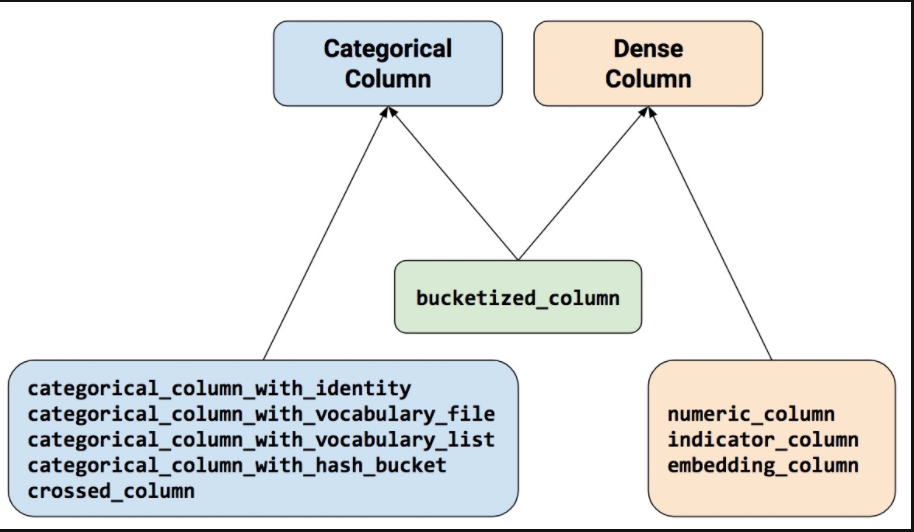
所有的Catogorical Column类型最终都要通过indicator_column转换成Dense Column类型才能传入模型

In [5]:
printlog('step2: make feature columns...')
feature_columns = []

#数值列 tf.feature_column.numeric_column
for col in ['age','fare','parch','sibsp'] + [c for c in dfdata.columns if c.endswith('_nan')]:
    feature_columns.append(tf.feature_column.numeric_column(col))

#分桶列
age = tf.feature_column.numeric_column('age')
age_buckets = tf.feature_column.bucketized_column(age,
                            boundaries = [18,25,30,35,40,45,50,55,60,65])
feature_columns.append(age_buckets)

#类别列
#Catogorical Column最终需要通过indicator_column转换成Dense Column
sex = tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(
      key = 'sex', vocabulary_list = ['male','female']))
feature_columns.append(sex)

pclass = tf.feature_column.indicator_column(
         tf.feature_column.categorical_column_with_vocabulary_list(
         key = 'pclass', vocabulary_list = [1,2,3]))    ##Note here [1,2,3] not ['1','2','3']
feature_columns.append(pclass)

##数据文字较多时使用categorical_column_with_hash_bucket

ticket = tf.feature_column.indicator_column(
         tf.feature_column.categorical_column_with_hash_bucket('ticket',3))
feature_columns.append(ticket)

embarked = tf.feature_column.indicator_column(
           tf.feature_column.categorical_column_with_vocabulary_list(
           key = 'embarked',vocabulary_list = ['S','C','B']))
feature_columns.append(embarked)

#嵌入列 少文本类型数据适合使用embedding 维度为数据类别数量的4次方根
##tf.feature_column.embedding_column(k,size = 四次方根维度)
## 注意cabin和ticket为什么cabin是嵌入类而ticket是indicator？  因为ticket只有大概三个类别，然而cabin有32个类别，不容易indicate
cabin = tf.feature_column.embedding_column(
        tf.feature_column.categorical_column_with_hash_bucket('cabin',32),2)
feature_columns.append(cabin)

#交叉列 crossed_column 交叉列，可以由除categorical_column_with_hash_bucket的任意分类列构成。
pclass_cate = tf.feature_column.categorical_column_with_vocabulary_list(
            key = 'pclass', vocabulary_list = [1,2,3])

crossed_feature = tf.feature_column.indicator_column(
                  tf.feature_column.crossed_column([age_buckets, pclass_cate], hash_bucket_size = 15))
feature_columns.append(crossed_feature)


================================================================================2022-01-13 16:10:59
step2: make feature columns......




# 定义和训练模型

In [6]:
printlog('step 3: define model...')

tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    layers.DenseFeatures(feature_columns),      #将特征列放入tf.kearas.layers.DenseFeatures中
    layers.Dense(64, activation = 'relu'),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')])


================================================================================2022-01-13 16:10:59
step 3: define model......




In [20]:
printlog('step 4: train model...')
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

history = model.fit(ds_train,
          validation_data=ds_test,
          epochs=20)


================================================================================2022-01-13 16:18:08
step 4: train model......


Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
 1/23 [>.............................] - ETA: 22s - loss: 0.4671 - accuracy: 0.8125WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'pclass': <tf.Tensor 'IteratorGetNext:8' shape=(None,) dtype=int32>, 'sex': <tf.Tensor 'IteratorGetNext:9' shape=(None,) dtype=string>, 'age': <tf.Tensor 'IteratorGetNext:0' shape=(None,) dtype=float32>, 'sibsp': <tf.Tensor 'IteratorGetNext:10' shape=(None,) dtype=int32>, 'parch': <tf.Tensor 'IteratorGetNext:7' shape=(None,) dtype=int32>, 'ticket': <tf.Tensor 'IteratorGetNext:11' shape=(None,) dtype=string>, 'fare': <tf.Tensor 'IteratorGetNext:6' shape=(None,) dtype=float32>, 'cabin': <tf.Tensor 'IteratorGetNext:2' shape=(None,) dtyp

In [18]:
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_features (DenseFeatur  multiple                 64        
 es)                                                             
                                                                 
 dense (Dense)               multiple                  3008      
                                                                 
 dense_1 (Dense)             multiple                  4160      
                                                                 
 dense_2 (Dense)             multiple                  65        
                                                                 
Total params: 7,297
Trainable params: 7,297
Non-trainable params: 0
_________________________________________________________________


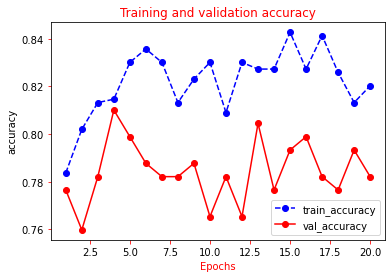

In [21]:
%matplotlib inline
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric, color = 'r')
    plt.xlabel("Epochs",color = 'red')
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.tick_params(axis = 'both',color = 'r')
    plt.show()
plot_metric(history,'accuracy')
